In [2]:
%reset -f
import pandas as pd
import numpy as np
from utils import *
from wavhandler import *
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import xgboost
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
import logging
logger = logging.getLogger()
logger.propagate = False
logger.setLevel(logging.ERROR)
np.random.seed(0)

In [3]:
filename = 'mosquitos.csv'
df = pd.read_csv(os.path.join(TEMP_DATADIR, filename), delimiter=';', index_col=0)

In [4]:
print(df.shape)
df.sample(5)

(279566, 16)


,fname,pow0,pow1,pow2,fr0,fr1,fr2,damping_0,damping_1,damping_2,names,pathlen,fnamelen,temp,humd,label
101434,F170301_105922_039_G_050_T_25.2_H_51.1,0.153771,0.001028,0.000127,1148.437500,2298.828125,3447.265625,0.021259,0.011895,0.005666,/home/kalfasyan/data/insects/Wingbeats/Ae. alb...,9,9,25.2,51.1,Ae. albopictus
212333,F161220_191503_093_G_050,0.040789,0.009157,0.001568,392.578125,792.968750,1188.476562,0.034826,0.049261,0.017666,/home/kalfasyan/data/insects/Wingbeats/C. quin...,9,5,NaN,NaN,C. quinquefasciatus
161097,F170201_230126_093_G_050,0.139732,0.058833,0.010069,377.929688,747.070312,1094.726562,0.074935,0.035948,0.012935,/home/kalfasyan/data/insects/Wingbeats/An. ara...,9,5,NaN,NaN,An. arabiensis
62293,F170209_165233_242_G_050,0.147702,0.043849,0.014633,542.968750,1066.406250,1656.250000,0.046763,0.013736,0.017983,/home/kalfasyan/data/insects/Wingbeats/Ae. aeg...,9,5,NaN,NaN,Ae. aegypti
35574,F170211_085941_097_G_050,0.111529,0.063324,0.025073,447.265625,890.625000,1347.656250,0.081878,0.035088,0.020290,/home/kalfasyan/data/insects/Wingbeats/Ae. aeg...,9,5,NaN,NaN,Ae. aegypti


In [5]:
df['date'] = df['fname'].apply(lambda x: pd.to_datetime(x.split('_')[0] + x.split('_')[1], format='F%y%m%d%H%M%S'))

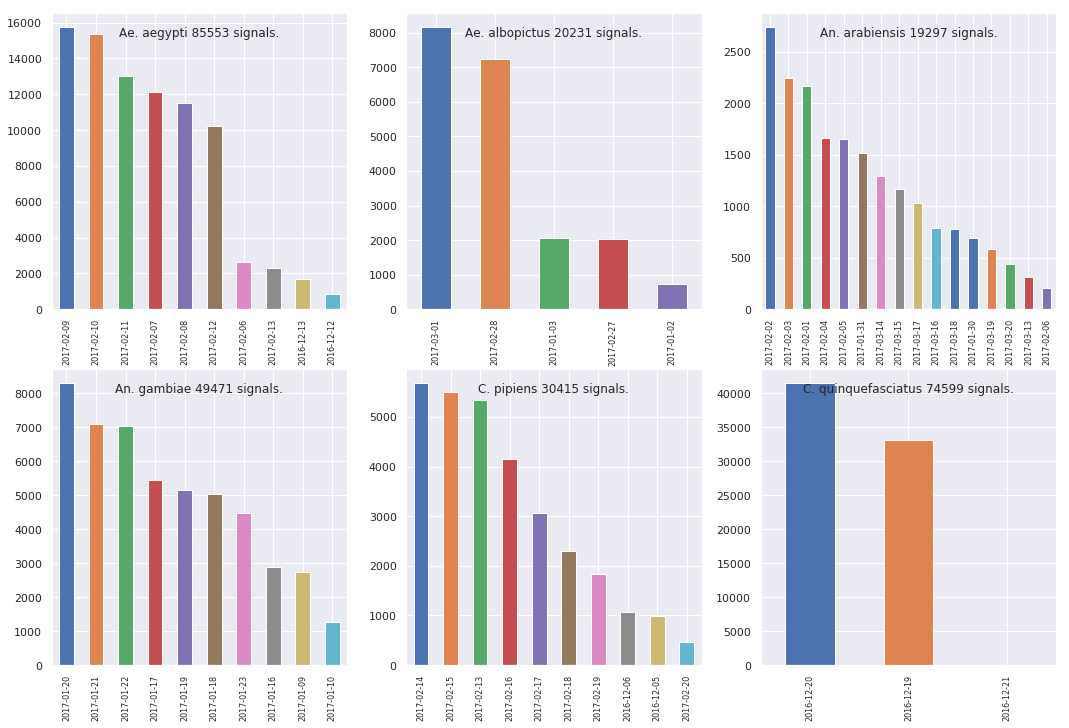

In [6]:
plt.figure(figsize=(18,12))
plt.tight_layout()
for q, (i, sub) in enumerate(df.groupby('label')):
    plt.subplot(2,3,q+1)
    plt.title(sub.label.unique()[0] +' '+ str(sub.shape[0])+' signals.', y=0.9)
    sub.date.dt.to_period('d').value_counts().plot(kind='bar')
    plt.xticks(rotation=90, fontsize=8)


In [49]:
df[df.label==class_label].date.dt.to_period('d').value_counts().index.tolist()

[Period('2017-02-09', 'D'),
 Period('2017-02-10', 'D'),
 Period('2017-02-11', 'D'),
 Period('2017-02-07', 'D'),
 Period('2017-02-08', 'D'),
 Period('2017-02-12', 'D'),
 Period('2017-02-06', 'D'),
 Period('2017-02-13', 'D'),
 Period('2016-12-13', 'D'),
 Period('2016-12-12', 'D')]

In [41]:
class_label = 'Ae. aegypti'

selected_period1 = pd.Period('2017-02-09', 'D')
X1_names = df[(df.label==class_label) & (df.date.dt.to_period('d') == selected_period1)].names
X1 = transform_data(read_simple(X1_names)[0].T)
y1 = np.ones(len(X1_names))

selected_period2 = pd.Period('2017-02-10', 'D')
X2_names = df[(df.label==class_label) & (df.date.dt.to_period('d') == selected_period2)].names
X2 = transform_data(read_simple(X2_names)[0].T)
y2 = np.zeros(len(X2_names))

100%|██████████| 15393/15393 [00:08<00:00, 1802.01it/s]


In [42]:
X = np.vstack((X1,X2))
y = np.vstack((y1.reshape(-1,1),y2.reshape(-1,1))).ravel()

X, y = shuffle(X, y, random_state=3)

from imblearn.under_sampling import RandomUnderSampler
ros = RandomUnderSampler(random_state=0)
ros.fit(X,y)
X, y = ros.fit_resample(X,y)
print('After undersampling: \n{}\n'.format(pd.DataFrame(y).iloc[:,0].value_counts()))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(random_state=0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

ac = accuracy_score(y_test, y_pred)
#cv_ac = cross_val_score(classifier, X, y, cv=3, scoring='accuracy')
print("ac: %f" % ac)
#print("Name: %s, cv_ac: %f" % ('...', np.mean(cv_ac)))

After undersampling: 
1.0    15393
0.0    15393
Name: 0, dtype: int64

ac: 0.580221


In [40]:
# feature_importances = pd.DataFrame(classifier.feature_importances_,
#                                     columns=['importance']).sort_values('importance', ascending=False)
# feature_importances.head(10)

In [59]:
df_x1 = pd.DataFrame(X1.T).describe()
df_x2 = pd.DataFrame(X2.T).describe()

In [79]:
df_x1

,0,1,2,3,4,5,6,7,8,9,...,15756,15757,15758,15759,15760,15761,15762,15763,15764,15765
count,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,...,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000
mean,-93.322220,-96.277504,-97.909775,-92.013000,-97.635704,-90.239464,-94.237000,-94.656425,-95.672462,-95.150589,...,-86.354507,-91.448380,-94.884499,-95.906784,-91.684196,-92.316780,-97.107079,-90.181580,-92.812668,-96.816078
std,9.062189,9.217363,6.804838,11.703687,7.559670,10.245791,10.466018,8.915739,9.885062,9.648490,...,10.583333,10.138659,9.056091,8.527322,9.489418,10.726734,7.578024,10.928696,10.697070,7.026321
min,-107.764702,-107.648811,-108.866417,-104.415459,-109.117554,-104.950386,-107.956863,-107.644096,-108.346931,-109.363411,...,-106.199524,-107.838043,-105.807152,-107.097389,-106.217155,-108.437027,-106.662643,-103.883690,-105.706757,-109.760628
25%,-100.471077,-101.326248,-101.996078,-99.555550,-101.339722,-97.437408,-100.820000,-100.554207,-101.636284,-101.225197,...,-95.186775,-98.648994,-100.434898,-100.600952,-98.401077,-99.722221,-101.271339,-98.993484,-99.978172,-102.031372
50%,-94.075432,-99.755722,-98.977470,-97.139648,-99.749008,-93.278999,-98.539177,-98.524620,-99.721138,-98.458923,...,-86.067741,-93.689308,-98.070885,-98.570198,-93.848030,-96.849205,-99.057121,-93.443672,-96.879555,-98.769249
75%,-89.637962,-95.373581,-96.502815,-86.790054,-97.661797,-84.273033,-89.605545,-90.280540,-90.741875,-91.528038,...,-78.539551,-86.770767,-93.510406,-95.142662,-86.004684,-86.803139,-96.068489,-84.266708,-88.596664,-92.798553
max,-61.288853,-63.782677,-72.015648,-55.537125,-70.997459,-66.779381,-63.244247,-69.089104,-64.267891,-59.878101,...,-61.499737,-65.480194,-71.799088,-64.932434,-65.840805,-58.506016,-67.701004,-58.604206,-60.240242,-76.250977


In [66]:
df_x1.index.tolist()

['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']

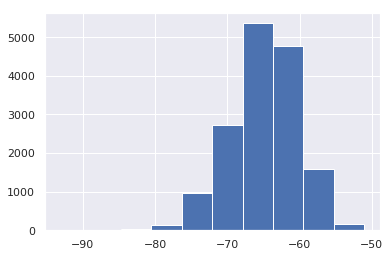

In [77]:
metric = 'max'
df_x1.loc[metric].hist()

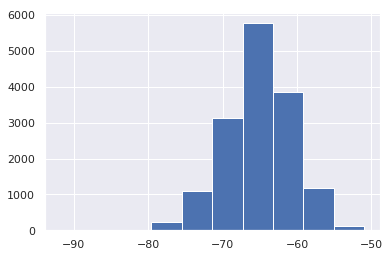

In [78]:
df_x2.loc[metric].hist()